In [2]:
from ephys import core, events
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import combinations
%matplotlib inline

In [3]:
# Set up birds and block_paths
birds = ['B1083', 'B1056', 'B1235', 'B1075']
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

bird = 'B1056'
block_path = bps[bird]

# load spikes, stimuli, clusters
spikes = core.load_spikes(block_path)
clusters = core.load_clusters(block_path)
trials = events.load_trials(block_path)

In [4]:
def get_average_firing_rate(spikes, cluster_id, t_start, t_end, fs):
    '''
    Compute the average firing rate of the cluster <cluster_id> during the time interval [t_start, t_end]
    Average firing rate is (# of spikes in interval) / (duration of interval)
    '''
    cluster_spikes_in_interval = spikes[(spikes['cluster'] == cluster_id) &
                            (spikes['time_samples'] < t_end) & 
                            (spikes['time_samples'] > t_start)
    ]
    n_spikes = cluster_spikes_in_interval.size
    dt = (t_end - t_start) / fs
    return n_spikes / dt

def get_stimulus_average_firing_rate(spikes, trials, cluster_id, stimulus_id, fs):
    '''
    Return the average firing rate of a neuron over all trials from a given stimulus
    '''
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    avg_fr = 0
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        avg_fr += get_average_firing_rate(spikes , cluster_id, s_start, s_end, fs)
    return avg_fr / stim_trials.size

def get_stimulus_avg_sd_firing_rate(spikes, trials, cluster_id, stimulus_id, fs, interval=[0,1]):
    '''
    Return the mean and standard deviation firing rate of a neuron over all trials from a given stimulus
    '''
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    fr_list=[]
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        int_start = int(s_start + (s_end - s_start)*interval[0])
        int_end = int(s_start + (s_end - s_start)*interval[1])
        fr_list.append(get_average_firing_rate(spikes , cluster_id, int_start, int_end, fs))
        
    return (np.mean(fr_list), np.std(fr_list))

    
def get_pair_stimulus_average_responses(spikes, trials, cluster_a, cluster_b, fs):
    '''
    Get the average responses from all stimuli for a pair of cells
    '''
    
    stimuli = sorted(trials['stimulus'].unique())
    ret = []
    for stim in stimuli:
        cluster_a_avg_response = get_stimulus_average_firing_rate(spikes, trials, cluster_a, stim, fs)
        cluster_b_avg_response = get_stimulus_average_firing_rate(spikes, trials, cluster_b, stim, fs)
        ret.append([cluster_a_avg_response, cluster_b_avg_response])
    return np.array(ret)


### Noise correlation funcs
def get_zscore_responses(spikes, trials, cluster_id, stimulus_id, fs, interval=[0, 1]):
    ''' Return an array of the z-scored responses from each trial for a given stim and cell'''
    
    # get mean and standard deviation response
    degenerate = False
    mu, sig = get_stimulus_avg_sd_firing_rate(spikes, trials, cluster_id, stimulus_id, fs, interval=interval)
    if (sig < 1e-12):
        print("Uh Oh... standard deviation very small")
        print("Cluster: {} Stimulus: {} mu: {} sigma: {}".format(cluster_id, stimulus_id, mu, sig))
        degenerate = True
    
    # for each trial compute z-score
    stim_trials = trials[trials['stimulus'] == stimulus_id]
    stim_starts = np.array(stim_trials['time_samples'])
    stim_ends = np.array(stim_trials['stimulus_end'])
    
    stim_clu_zscores = []
    for (s_start, s_end) in zip(stim_starts, stim_ends):
        int_start = int(s_start + (s_end - s_start)*interval[0])
        int_end = int(s_start + (s_end - s_start)*interval[1])
        if degenerate:
            stim_clu_zscores.append(0.0)
        else:
            trial_fr = get_average_firing_rate(spikes, cluster_id, int_start, int_end, fs)
            zscore = (trial_fr - mu)/sig
            stim_clu_zscores.append(zscore)
    return np.array(stim_clu_zscores)
    
def get_stim_zscores(spikes, trials, clusters, stimulus_id, fs, interval=[0, 1]):
    ''' Get an ncell x ntrial array of zscores for a given stim'''
    
    stimulus_zscores = []
    for cluster in clusters:
        stimulus_zscores.append(get_zscore_responses(spikes, trials, cluster, stimulus_id, fs, interval=interval))
    return np.vstack(stimulus_zscores)

def get_all_stim_zscores(spikes, trials, clusters, fs, interval=[0, 1]):
    ''' Return an ncell x ntrial x nstim array of zscores'''
    
    stimuli = sorted(trials['stimulus'].unique())
    all_stim_zscores = []
    for stim in stimuli:
        all_stim_zscores.append(get_stim_zscores(spikes, trials, clusters, stim, fs, interval=interval))
    return np.dstack(all_stim_zscores)
    
def get_pair_noise_correlation(stim_zscores, cluster_a, cluster_b):
    '''
    given an ncell x ntrial array of z-scores, compute the noise correlation between cells index a and index b
    cluster_a is the *index* of the cell, not its id
    '''

    z_a = stim_zscores[cluster_a, :]
    z_b = stim_zscores[cluster_b, :]
    return pearsonr(z_a, z_b)[0]

def get_pair_stim_avg_noise_correlation(all_stim_zscores, cluster_a, cluster_b):
    '''
    For a pair of cells given by *index* cluster_a, cluster_b, compute the noise correlation averaged over all stimuli
    
    '''
    
    nstim = all_stim_zscores.shape[2]
    corrs = []
    for stimnum in range(nstim):
        corrs.append(get_pair_noise_correlation(all_stim_zscores[:, :, stimnum], cluster_a, cluster_b))
    return np.mean(corrs)

def get_all_stim_avg_noise_correlation(all_stim_zscores, clusters):
    ''' Compute the stimulus averaged noise correlation from all pairs of cells
    all_stim_zscores is an ncell x ntrial x nstim array
    
    '''
    
    all_noise_corrs = []
    for pair in tqdm(combinations(range(len(clusters)),2)):
        all_noise_corrs.append(get_pair_stim_avg_noise_correlation(all_stim_zscores, pair[0], pair[1]))
    return np.array(all_noise_corrs)
    
###################################   
## Signal correlations
def get_signal_correlation(spikes, trials, cluster_a, cluster_b, fs):
    ''' Compute the signal correlation for a pair of cells
    
    spikes - spikes dataframe
    trials - trials dataframe containing all the trials for which you wish to compute signal correlations
                (e.g. all the trials from a particular class of stimuli)
    cluster_a - the *cluster id* of the first cell in the pair
    cluster_b - the *cluster id* of the second cell in the pair
    fs - sampling rate
    '''
    
    stim_responses = get_pair_stimulus_average_responses(spikes, trials, cluster_a, cluster_b, fs)
    stim_correlation = pearsonr(stim_responses[:, 0], stim_responses[:, 1])[0]
    return stim_correlation

def get_all_average_responses(spikes, trials, clusters, fs):
    ''' Return an ncell x nstim matrix of trial-averaged firing rate responses 
        spikes - spikes dataframe
        trials - trials dataframe containing all the trials for which you wish to compute signal correlations
                (e.g. all the trials from a particular class of stimuli)
        clusters - list of *cluster ids* for which you wish to compute average responses
                    the output array will have clusters indexed in this order
    '''
    
    stimuli = sorted(trials['stimulus'].unique())
    responses = np.zeros((len(clusters), len(stimuli)))
    for i in tqdm(range(len(clusters))):
        for j in range(len(stimuli)):
            responses[i, j] = get_stimulus_average_firing_rate(spikes, trials, clusters[i], stimuli[j], fs)
    return responses

from tqdm import tqdm
def get_all_signal_correlations(responses, clusters):
    ''' given an ncell x nstim matrix of trial averaged firing rate responses, 
    compute the signal correlations for every pair.
    
    responses - an ncell x nstim matrix of trial averaged firing rate responses
    clusters - array of *cluster ids* corresponding to the order of the rows in the response matrix
    '''
    all_pairs_signal_correlations = []
    for pair in tqdm(combinations(range(len(clusters)), 2)):
        response_a = responses[pair[0], :]
        response_b = responses[pair[1], :]
        pair_sig_corr = pearsonr(response_a, response_b)[0]
        all_pairs_signal_correlations.append(pair_sig_corr)
    return np.array(all_pairs_signal_correlations)

In [5]:
good_clusters = clusters[clusters['quality'] == 'Good']['cluster'].unique()
fs = 30000

responses = get_all_average_responses(spikes, trials, good_clusters, fs)
signal_corrs = get_all_signal_correlations(responses, good_clusters)

zscores = get_all_stim_zscores(spikes, trials, good_clusters, fs)
noise_corrs = get_all_stim_avg_noise_correlation(zscores, good_clusters)

100%|██████████| 54/54 [00:27<00:00,  1.95it/s]
1431it [00:00, 17400.98it/s]
1431it [00:01, 1102.47it/s]


(array([ 2.,  3.,  3., 10., 11., 16., 21., 18., 41., 40., 55., 65., 69.,
        68., 71., 69., 71., 73., 84., 77., 67., 59., 58., 62., 63., 71.,
        46., 30., 27., 23., 23., 12., 10., 10.,  3.]),
 array([-0.54140123, -0.49921009, -0.45701896, -0.41482782, -0.37263669,
        -0.33044555, -0.28825442, -0.24606328, -0.20387215, -0.16168101,
        -0.11948987, -0.07729874, -0.0351076 ,  0.00708353,  0.04927467,
         0.0914658 ,  0.13365694,  0.17584807,  0.21803921,  0.26023034,
         0.30242148,  0.34461261,  0.38680375,  0.42899488,  0.47118602,
         0.51337716,  0.55556829,  0.59775943,  0.63995056,  0.6821417 ,
         0.72433283,  0.76652397,  0.8087151 ,  0.85090624,  0.89309737,
         0.93528851]),
 <a list of 35 Patch objects>)

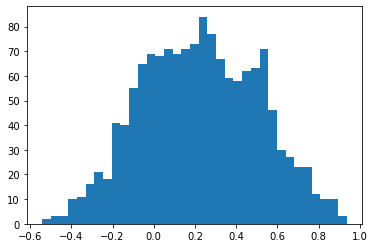

In [6]:
plt.hist(signal_corrs, bins=35)

(array([  6.,   6.,   7.,   9.,   8.,  16.,  17.,  15.,  33.,  33.,  49.,
         70.,  72., 112., 145., 128., 119., 120.,  78.,  82.,  67.,  54.,
         41.,  31.,  18.,  18.,  14.,  16.,  16.,   7.,   9.,   4.,   6.,
          3.,   2.]),
 array([-0.54564808, -0.50818256, -0.47071704, -0.43325152, -0.395786  ,
        -0.35832048, -0.32085496, -0.28338944, -0.24592392, -0.2084584 ,
        -0.17099288, -0.13352736, -0.09606184, -0.05859632, -0.0211308 ,
         0.01633472,  0.05380024,  0.09126576,  0.12873128,  0.1661968 ,
         0.20366232,  0.24112784,  0.27859336,  0.31605888,  0.3535244 ,
         0.39098992,  0.42845544,  0.46592096,  0.50338648,  0.540852  ,
         0.57831752,  0.61578304,  0.65324856,  0.69071408,  0.7281796 ,
         0.76564512]),
 <a list of 35 Patch objects>)

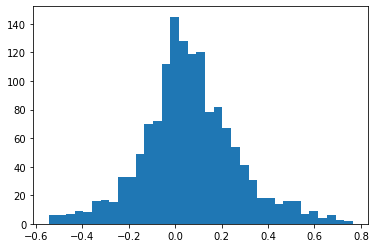

In [7]:
plt.hist(noise_corrs, bins=35)

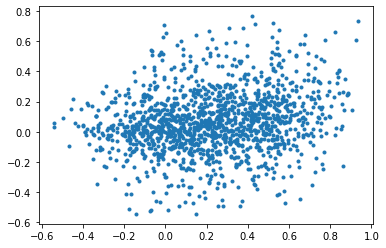

In [8]:
plt.plot(signal_corrs, noise_corrs, '.')

In [9]:
nas = np.logical_or(np.isnan(signal_corrs), np.isnan(noise_corrs))
print(pearsonr(signal_corrs[~nas], noise_corrs[~nas]))

(0.1909863706533356, 3.2027077280308887e-13)


In [ ]:
np.isnan(noise_corrs[nas]).any()

In [14]:
np.nanmean(noise_corrs)

0.13047003382751018

In [10]:
stimuli = sorted(trials['stimulus'].unique())
print(stimuli)

['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung', 'E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung', 'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']


In [11]:
fam_stim = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']
all_unfam_stim = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung','I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung', 'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']
# unfam_stim = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']
# unfam_stim = ['I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung',]
# unfam_stim = ['M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung']

#unfam_stim = np.random.choice(all_unfam_stim, size=4, replace=False)
unfam_stim = all_unfam_stim

fam_trials = trials[trials['stimulus'].isin(fam_stim)]
unfam_trials = trials[trials['stimulus'].isin(unfam_stim)]

In [12]:
fam_responses = get_all_average_responses(spikes, fam_trials, good_clusters, fs)
unfam_responses = get_all_average_responses(spikes, unfam_trials, good_clusters, fs)
fam_signal_corrs = get_all_signal_correlations(fam_responses, good_clusters)
unfam_signal_corrs = get_all_signal_correlations(unfam_responses, good_clusters)

fam_zscores = get_all_stim_zscores(spikes, fam_trials, good_clusters, fs)
fam_noise_corrs = get_all_stim_avg_noise_correlation(fam_zscores, good_clusters)
unfam_zscores = get_all_stim_zscores(spikes, unfam_trials, good_clusters, fs)
unfam_noise_corrs = get_all_stim_avg_noise_correlation(unfam_zscores, good_clusters)

100%|██████████| 54/54 [00:20<00:00,  2.62it/s]
1431it [00:00, 19826.34it/s]
1431it [00:00, 19444.12it/s]
1431it [00:00, 4149.60it/s]
1431it [00:00, 1431.53it/s]


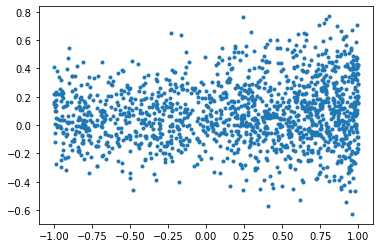

In [13]:
plt.plot(fam_signal_corrs, fam_noise_corrs, '.')

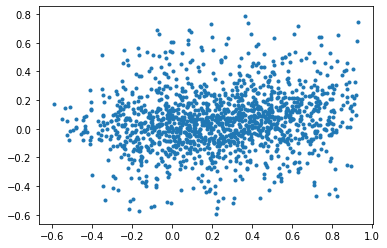

In [14]:
plt.plot(unfam_signal_corrs, unfam_noise_corrs, '.')

In [15]:
nas = np.logical_or(np.isnan(fam_signal_corrs), np.isnan(fam_noise_corrs))
print(pearsonr(fam_signal_corrs[~nas], fam_noise_corrs[~nas]))

(0.1015521641143571, 0.00011900484714672046)


In [16]:
nas = np.logical_or(np.isnan(unfam_signal_corrs), np.isnan(unfam_noise_corrs))
print(pearsonr(unfam_signal_corrs[~nas], unfam_noise_corrs[~nas]))

(0.16291628395669083, 5.683704042238378e-10)


(array([ 38.,  28.,  31.,  42.,  23.,  31.,  17.,  29.,  28.,  20.,  29.,
         32.,  30.,  34.,  35.,  25.,  19.,  26.,  28.,  34.,  39.,  45.,
         47.,  41.,  52.,  41.,  38.,  53.,  54.,  59.,  72.,  55.,  73.,
         77., 106.]),
 array([-0.99996098, -0.94282713, -0.88569327, -0.82855942, -0.77142557,
        -0.71429171, -0.65715786, -0.600024  , -0.54289015, -0.4857563 ,
        -0.42862244, -0.37148859, -0.31435474, -0.25722088, -0.20008703,
        -0.14295317, -0.08581932, -0.02868547,  0.02844839,  0.08558224,
         0.1427161 ,  0.19984995,  0.2569838 ,  0.31411766,  0.37125151,
         0.42838537,  0.48551922,  0.54265307,  0.59978693,  0.65692078,
         0.71405464,  0.77118849,  0.82832234,  0.8854562 ,  0.94259005,
         0.9997239 ]),
 <a list of 35 Patch objects>)

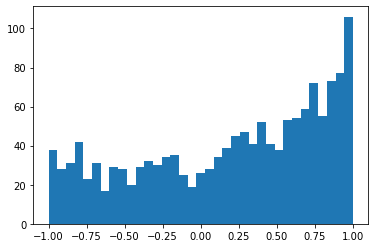

In [17]:
plt.hist(fam_signal_corrs, bins=35)

(array([ 2.,  6.,  4., 10.,  8., 17., 16., 34., 37., 47., 39., 48., 57.,
        66., 66., 68., 62., 61., 69., 63., 61., 72., 61., 56., 66., 55.,
        52., 39., 39., 34., 37., 29., 20., 15., 15.]),
 array([-0.59252129, -0.54897846, -0.50543563, -0.4618928 , -0.41834997,
        -0.37480714, -0.33126431, -0.28772148, -0.24417866, -0.20063583,
        -0.157093  , -0.11355017, -0.07000734, -0.02646451,  0.01707832,
         0.06062114,  0.10416397,  0.1477068 ,  0.19124963,  0.23479246,
         0.27833529,  0.32187812,  0.36542095,  0.40896377,  0.4525066 ,
         0.49604943,  0.53959226,  0.58313509,  0.62667792,  0.67022075,
         0.71376358,  0.7573064 ,  0.80084923,  0.84439206,  0.88793489,
         0.93147772]),
 <a list of 35 Patch objects>)

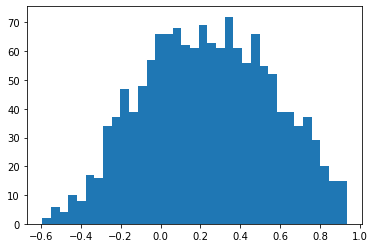

In [18]:
plt.hist(unfam_signal_corrs, bins=35)

(array([  1.,   1.,   2.,   1.,  10.,   8.,  12.,  17.,  23.,  37.,  34.,
         50.,  78.,  84.,  92., 109., 109., 101., 105.,  94.,  77.,  74.,
         65.,  49.,  38.,  41.,  34.,  24.,  18.,  17.,   8.,   6.,   5.,
          4.,   3.]),
 array([-0.62663013, -0.58678107, -0.54693201, -0.50708295, -0.46723388,
        -0.42738482, -0.38753576, -0.3476867 , -0.30783764, -0.26798858,
        -0.22813952, -0.18829046, -0.14844139, -0.10859233, -0.06874327,
        -0.02889421,  0.01095485,  0.05080391,  0.09065297,  0.13050203,
         0.1703511 ,  0.21020016,  0.25004922,  0.28989828,  0.32974734,
         0.3695964 ,  0.40944546,  0.44929452,  0.48914359,  0.52899265,
         0.56884171,  0.60869077,  0.64853983,  0.68838889,  0.72823795,
         0.76808702]),
 <a list of 35 Patch objects>)

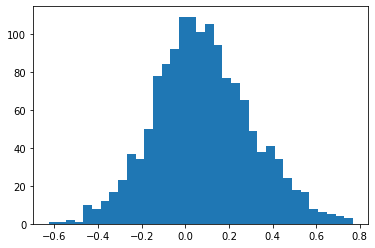

In [19]:
plt.hist(fam_noise_corrs, bins=35)

(array([  3.,   5.,   8.,   5.,  12.,  12.,  17.,  11.,  29.,  40.,  37.,
         60.,  81., 102., 123., 129., 135., 119., 110.,  89.,  62.,  58.,
         43.,  26.,  18.,  17.,  20.,  14.,  16.,   6.,   7.,   9.,   3.,
          4.,   1.]),
 array([-0.59324146, -0.55387894, -0.51451642, -0.4751539 , -0.43579138,
        -0.39642886, -0.35706635, -0.31770383, -0.27834131, -0.23897879,
        -0.19961627, -0.16025375, -0.12089124, -0.08152872, -0.0421662 ,
        -0.00280368,  0.03655884,  0.07592136,  0.11528387,  0.15464639,
         0.19400891,  0.23337143,  0.27273395,  0.31209647,  0.35145898,
         0.3908215 ,  0.43018402,  0.46954654,  0.50890906,  0.54827158,
         0.58763409,  0.62699661,  0.66635913,  0.70572165,  0.74508417,
         0.78444669]),
 <a list of 35 Patch objects>)

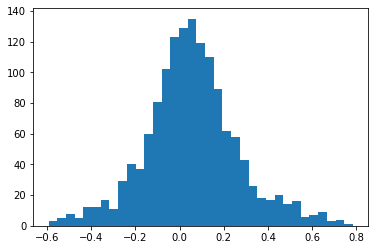

In [20]:
plt.hist(unfam_noise_corrs, bins=35)

In [21]:
np.nanmean(fam_noise_corrs)

0.08152541617396225

In [22]:
np.nanmean(unfam_noise_corrs)

0.05641289011379974

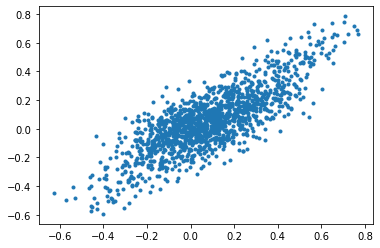

In [23]:
plt.plot(fam_noise_corrs, unfam_noise_corrs, '.')

In [ ]:
test = get_stim_zscores(spikes, trials, good_clusters, 'P_40k', fs)

In [ ]:
test.shape

In [ ]:
stim_subintervals = np.linspace(0, 1, 7)
subint_noisecorrs = []
for (a, b) in tqdm(zip(stim_subintervals[:-1], stim_subintervals[1:])):
    subint_zscores = get_all_stim_zscores(spikes, trials, good_clusters, fs, interval=[a,b])
    subint_noisecorrs.append(get_all_stim_avg_noise_correlation(subint_zscores, good_clusters))

In [ ]:
subint_noisecorrs[0].shape

In [ ]:
nc_v_time = np.array([(i, x) for i, y in enumerate(subint_noisecorrs) for x in y ])
mean_nc_v_time = np.array([(i, np.nanmean(x)) for i, x in enumerate(subint_noisecorrs)])
std_nc_v_time = np.array([(i, np.nanstd(x)) for i, x in enumerate(subint_noisecorrs)])

In [ ]:
plt.plot(nc_v_time[:, 0],  nc_v_time[:, 1], '.')

In [ ]:
plt.plot(mean_nc_v_time[:, 0], mean_nc_v_time[:, 1])